In [84]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd 
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
import math
from scipy.optimize import minimize

## Group Assignment
### Team Number: 19
### Team Member Names: Jay, Manal, Sardul
### Team Strategy Chosen: Risk Free

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here. Jay, Manal, Sardul

### Ticker Filtering and Data Validation

In this step, we load a list of candidate tickers from a CSV file and apply several filters to ensure only high-quality, valid stocks are used for portfolio construction. This helps remove tickers that are delisted, illiquid, or lacking recent price data, which could bias our safety scoring.

- **Currency check (USD/CAD)** - Ensures we only invest in North American markets that we can properly analyze and convert to CAD.

- **Empty DataFrames** - Prevents inclusion of delisted or inactive stocks with no historical data, which would break calculations.

- **Volume < 5000** - Filters out illiquid stocks that are harder to buy/sell efficiently and may have abnormal return behavior.

- **Average price > $2.5** - Avoids highly volatile penny stocks which can distort risk metrics.

In [85]:
td = yf.Ticker("TD.TO")
td_nyse = yf.Ticker("TD")

print(td.info.get('longName'))
print(td_nyse.info.get('longName'))

The Toronto-Dominion Bank
The Toronto-Dominion Bank


In [86]:
CSV_FILE_NAME = "Tickers.csv"
tickers_csv = pd.read_csv(CSV_FILE_NAME, header=None)
tickers_unflitered = tickers_csv.iloc[:, 0].tolist()

long_term_start_date = '2024-05-01'
short_term_start_date = '2025-08-01'
end_date = '2025-11-21'

stocks_std = {}
ticker_cleaned = []
cleaned_long_names = [] 

# Filter the tickers
for t in tickers_unflitered:
    try:
        t = t.strip()
        ticker = yf.Ticker(t)
        info = ticker.info

        if info is None:
            continue

        currency = info.get('currency')
        quote_type = info.get('quoteType')
        market = info.get('market')

        # Filters out anything not an EQUITY (removes BTC, crypto, forex tickers)
        if quote_type != 'EQUITY':
            continue

        # Currency must be USD or CAD
        if currency not in ['USD', 'CAD']:
            continue

        # Market must be US or Canadian (extra safeguard)
        if market not in ['us_market', 'ca_market']:
            continue

        # Download price history
        ticker_hist_long_term = ticker.history(start=long_term_start_date, end=end_date)
        ticker_hist_short_term = ticker_hist_long_term.loc[short_term_start_date:]

        # Filters out stocks whose dataframe is empty
        if ticker_hist_long_term.empty or ticker_hist_short_term.empty:
            continue

        # Filters out stocks with average daily volume < 5000
        if ticker_hist_long_term['Volume'].mean() < 5000 or ticker_hist_short_term['Volume'].mean() < 5000:
            continue

        # Filters out cheap penny stocks (mean close < $2.5)
        if ticker_hist_long_term['Close'].mean() < 2.5:
            continue
        
        if info['longName'] in cleaned_long_names:
            continue

        # Appends the filtered tickers to a list
        ticker_cleaned.append(ticker.ticker)
        cleaned_long_names.append(ticker.info['longName'])

    except Exception as e:
        print(f"Skipping {t} due to error: {e}")
        continue

HTTP Error 404: 
HTTP Error 404: 


### **Strategy Chosen:**
We will develop a **score-based ranking system** to evaluate and select stocks for our risk-averse portfolio.  
Each stock is assigned a score based on multiple quantitative parameters that measure stability, volatility, market sensitivity, and diversification potential.


### **Dynamic Portfolio Selection Based on Risk Threshold**
Unlike traditional fixed-size portfolios, we implement an **adaptive selection strategy** that prioritizes stock quality over arbitrary portfolio size constraints. Our approach uses a **risk score threshold of 0.18** to identify and select only the safest stocks in our universe.

#### **Selection Logic**
We apply intelligent rules to balance risk minimization with diversification requirements:

1. **Threshold Filtering:** Select all stocks with risk scores below 0.15 (capturing only the top ~24 lowest-risk stocks)
2. **Minimum Diversification:** If fewer than 10 stocks qualify, select the top 10 to ensure adequate diversification
3. **Maximum Concentration:** If more than 25 stocks qualify, cap at the 25 lowest-risk stocks to avoid over-diversification
4. **Optimal Range:** If 10-25 stocks qualify, include all qualifying stocks (typical outcome)

This adaptive approach ensures our portfolio maintains strict risk criteria while achieving optimal diversification, regardless of market conditions.

### **Justification for Portfolio Size Strategy**

- **Market-Adaptive:**  
  Our threshold-based approach adjusts to real market conditions—selecting fewer stocks during high volatility and more during stable periods.

- **Strict Quality Control:**  
  A risk cutoff of **0.18** ensures only genuinely low-volatility, low-beta, and well-diversified stocks enter the portfolio, prioritizing safety over meeting an arbitrary stock count.

- **Optimal Diversification Range:**  
  Research (Elton & Gruber, 1977) shows that **20–30 stocks** achieve near-complete diversification. Our usual selection of 20–24 stocks falls within this range while maintaining stronger risk characteristics.



The parameters we evaluate are:

- **Stability Score (STAB)**  
  Use blended volatility concept + day-to-day choppiness,
  $$\text{VolScore} = 0.7 \times \sigma_{\text{longterm}} + 0.3 \times \sigma_{\text{shortterm}}$$

$$\text{STAB} = 0.7 \times \text{VolScore} + 0.3 \times \text{AbsAvgRetScore}$$


- **Beta (Market Sensitivity)**  
  A stock’s sensitivity to market movement. Lower absolute beta values indicate more stable, independent behavior.


- **Correlation Score (Diversification Metric)**  
  Even if a stock is low-risk individually, it may still be highly correlated with others.  
  For each stock, we compute its **average correlation with all other candidate stocks**.  
  A lower (or negative) average correlation indicates better diversification and receives a higher score.


- **Market Capitalization (Log Scaled)**  
  Larger companies tend to be more stable, But using market cap leads to giant companies from dominating the score. so we must
  log scale it.



**Weight of Each Parameter which calculating score:**
- **Stability** – 40%

- **Beta** – 20%

- **Average Correlation** – 25%

- **Size** – 15%

#### Justification why the following weights were selected
  - **Why Stability (Volatility) Gets the Highest Weight:**
    Volatility is the strongest predictor of downside risk in all major  empirical studies. These sources show Volatility explains 60–80% of total portfolio risk.

    *References*: 
    - https://www.msci.com/indexes/documents/methodology/3_MSCI_Minimum_Volatility_Advanced_Indexes_Methodology_20250203.pdf
    - https://pages.stern.nyu.edu/~jwurgler/papers/faj-benchmarks.pdf 
  
  - **Why Beta ≠ as important as raw volatility -> 20%**
    Beta is a secondary measure of market sensitivity. The CAPM literature (Sharpe 1964; Fama-French factor models) treats beta as one of several risk factors, not the main one. Real institutional models (BlackRock Aladdin, MSCI Barra) give beta less weight than volatility because volatility already captures much of the systematic risk.

  - **Why Diversification Gets 25%**
    Correlation-driven diversification is essential. If the stocks in the porfolio have high correlation they are likely to move together as 1 big stock, which is not ideal. 

    *References*:
    - Markowitz Modern Portfolio Theory (1952): diversification matters, but variance dominates optimization.
    https://www.investopedia.com/terms/m/modernportfoliotheory.asp

  - **Why Size Gets a Small Weight -> 15%**
    Larger firms have lower bankruptcy risk, Market cap is not a strong predictor of day-to-day volatility. Size is a stability proxy, not a primary risk factor.

    *References*:
    - Fama–French 3-Factor Model (1992) — includes size but not as a primary risk stabilizer
    https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp

    

#### **Key Problem**
One key problem identified is when we try to apply the formula with raw values can cause problems, as some parameters such as market cap have values in billions while Beta is less that 1. To solve this Each metric is normalized between **0 and 1**, and then the weighted scoring formula is applied: 


#### **Solution**
Conveniently we have Normalization Techniques in Pandas. We will be using The min-max feature scaling. It works by subtracting the minimum value of the feature then dividing by the range.

The **total score** determines the ranking of all candidate stocks.  
We then select the **top 25 stocks** with the lowest combined score.

In [87]:

returns_pct_all = pd.DataFrame()
for t in ticker_cleaned:
    ticker = yf.Ticker(t)
    ticker_hist_long_term = ticker.history(start=long_term_start_date,end=end_date)
    ticker_hist_short_term = ticker.history(start=short_term_start_date,end=end_date)
    
    # STD calculation for long and short term
    ticker_hist_short_term['% Change'] = 100*ticker_hist_short_term['Close'].pct_change()
    ticker_hist_long_term['% Change'] = 100*ticker_hist_long_term['Close'].pct_change()

    ticker_hist_long_term.dropna(inplace=True)
    ticker_hist_short_term.dropna(inplace=True)

    # Calculating average daily return -> Larger absolute move -> more choppy
    avg_daily_returns = abs(ticker_hist_long_term['% Change'].mean())

    # Higher priority given to long term std as it captures risk and consitency while short term volatality
    # can be used to flag recent instabality or volatality spikes

    std = 0.3*ticker_hist_short_term['% Change'].std() + 0.7*ticker_hist_long_term['% Change'].std()
    stab = 0.3*avg_daily_returns + 0.7*std

    # Calculating Beta
    currency = ticker.info.get('currency', 'USD')
    if currency == 'USD':
        index_name = '^GSPC'
    if currency == 'CAD':
        index_name = '^GSPTSE'
    index = yf.Ticker(index_name)
    index_hist_long_term = index.history(start = long_term_start_date,end = end_date)
    prices = pd.DataFrame({t: ticker_hist_long_term['Close'],index_name: index_hist_long_term['Close']})
    prices = prices.dropna()
    daily_returns = prices.pct_change(fill_method=None)
    MarketVar = daily_returns[index_name].var()
    Beta_matrix = daily_returns.cov()/MarketVar
    Beta = Beta_matrix.iat[0,1]

    #Calculating the correlation matrix
    returns_pct_all[t] = ticker_hist_long_term['% Change']

    # Calculating market cap and normalizing it by applying log 
    market_cap = np.log10(ticker.info['marketCap'])




    stocks_std[t] = [round(float(stab), 4), round(float(Beta), 4),round(float(market_cap), 4)]

# Making a table of tickers with their respective parameters raw value
Data = []
stock_name = []
for k,v in stocks_std.items():
    stock_name.append(k)
    Data.append(v)
df = pd.DataFrame(Data)
df.index = stock_name
df.columns = ['STAB','Beta','MarketCap']
df = df.reset_index().rename(columns={'index': 'Ticker'})

# Normalizing Data
df_final = df.copy()

# While normalizing we are not considering abs value of beta but the raw value since negative betas would stabalize our portfolio
# more since most stocks have positive betas
for column in df_final.columns:
    if column == 'Ticker':
        continue
    df_final[column] =  (df_final[column] - df_final[column].min()) / (df_final[column].max() - df_final[column].min())

df_final.head()


,Ticker,STAB,Beta,MarketCap
0,SU.TO,0.126361,0.461355,0.591962
1,ABBV,0.142299,0.160059,0.766543
2,LOW,0.103692,0.287689,0.650505
3,TD,0.036067,0.187315,0.656870
4,AMZN,0.246690,0.612937,0.951921


In [88]:
corr_matrix = returns_pct_all.corr()
corr_matrix.iloc[:5, :5]

,SU.TO,ABBV,LOW,TD,AMZN
SU.TO,1.000000,0.156878,0.158267,0.256012,0.261682
ABBV,0.156878,1.000000,0.232342,0.137104,0.007673
LOW,0.158267,0.232342,1.000000,0.296398,0.266467
TD,0.256012,0.137104,0.296398,1.000000,0.186715
AMZN,0.261682,0.007673,0.266467,0.186715,1.000000


In [89]:
avg_correlation = []
for t in df_final['Ticker']:
    avg_correlation.append(corr_matrix[t].drop(t).mean())
df_final['Average Correlation'] = avg_correlation
df_final


,Ticker,STAB,Beta,MarketCap,Average Correlation
0,SU.TO,0.126361,0.461355,0.591962,0.208564
1,ABBV,0.142299,0.160059,0.766543,0.139477
2,LOW,0.103692,0.287689,0.650505,0.250355
3,TD,0.036067,0.187315,0.656870,0.216130
4,AMZN,0.246690,0.612937,0.951921,0.249307
5,AXP,0.181287,0.568162,0.716390,0.328614
6,GCT,0.927231,0.788863,0.177584,0.182560
7,BK,0.082738,0.380629,0.593464,0.324846
8,EXE.TO,0.245357,0.240089,0.201015,0.113031
9,CMCSA,0.124425,0.271083,0.619017,0.220271


Since some parameters that have high values indicate higher stabality which parameters that have lower values indicate lower stabality. We must subtract 1 from those parameters whose higher values indicate higher stabality like market cap. We can also calculate the final score by applying the weight of each parameter and sort it in ascending order.

- Stability – 40%

- Beta – 20%

- Average Correlation – 25%

- Size – 15%

**Note: Lower the score, more stable the stock**

In [90]:
df_final['MarketCap'] = 1 - df_final['MarketCap']
df_final['Score'] = 0.4*df_final['STAB']+0.20*df_final['Beta']+0.15*df_final['MarketCap']+0.25*df_final['Average Correlation']
df_sorted = df_final.sort_values(by="Score", ascending=True)
df_sorted.reset_index(drop=True, inplace=True)
df_sorted

,Ticker,STAB,Beta,MarketCap,Average Correlation,Score
0,SO,0.008318,0.003130,0.381198,0.068692,0.078306
1,T.TO,0.011080,0.000000,0.510131,0.026666,0.087618
2,PEP,0.063244,0.051687,0.307661,0.116038,0.110794
3,COST,0.059720,0.252956,0.236794,0.183152,0.155786
4,TD,0.036067,0.187315,0.343130,0.216130,0.157392
5,ABBV,0.142299,0.160059,0.233457,0.139477,0.158819
6,RY.TO,0.000000,0.349765,0.264731,0.269312,0.176991
7,LOW,0.103692,0.287689,0.349495,0.250355,0.214028
8,CMCSA,0.124425,0.271083,0.380983,0.220271,0.216202
9,GOOG,0.203511,0.468006,0.000000,0.167994,0.217004


### **Dynamic Stock Selection Based on Risk Score Threshold**
This code block implements an adaptive portfolio selection strategy that prioritizes low-risk stocks while maintaining portfolio diversification requirements.

We use a risk score threshold of 0.2 to identify stocks with the lowest risk profiles. The algorithm then applies intelligent rules to ensure the portfolio maintains adequate diversification:

- Minimum portfolio size: 10 stocks (ensures sufficient diversification)
- Maximum portfolio size: 25 stocks (avoids over-diversification and maintains manageability)
- Selection criterion: Risk score < 0.2 (captures only the safest stocks)

In [91]:
RISK_SCORE_THRESHOLD = 0.2
low_risk_stocks = df_sorted[df_sorted['Score'] < RISK_SCORE_THRESHOLD]
num_low_risk_stocks = len(low_risk_stocks)

print(f"Number of stocks with risk score < {RISK_SCORE_THRESHOLD}: {num_low_risk_stocks}")

# Apply selection rules
if num_low_risk_stocks < 10:
    selected_stocks = df_sorted.iloc[0:10]
    print(f"Selected top 10 stocks (insufficient stocks below threshold)")
elif num_low_risk_stocks > 25:
    selected_stocks = low_risk_stocks.iloc[0:25]
    print(f"Selected top 25 from {num_low_risk_stocks} low-risk stocks")
else:
    selected_stocks = low_risk_stocks
    print(f"Selected all {num_low_risk_stocks} low-risk stocks")

print(f"Final selection: {len(selected_stocks)} stocks")
selected_stocks

Number of stocks with risk score < 0.2: 7
Selected top 10 stocks (insufficient stocks below threshold)
Final selection: 10 stocks


,Ticker,STAB,Beta,MarketCap,Average Correlation,Score
0,SO,0.008318,0.003130,0.381198,0.068692,0.078306
1,T.TO,0.011080,0.000000,0.510131,0.026666,0.087618
2,PEP,0.063244,0.051687,0.307661,0.116038,0.110794
3,COST,0.059720,0.252956,0.236794,0.183152,0.155786
4,TD,0.036067,0.187315,0.343130,0.216130,0.157392
5,ABBV,0.142299,0.160059,0.233457,0.139477,0.158819
6,RY.TO,0.000000,0.349765,0.264731,0.269312,0.176991
7,LOW,0.103692,0.287689,0.349495,0.250355,0.214028
8,CMCSA,0.124425,0.271083,0.380983,0.220271,0.216202
9,GOOG,0.203511,0.468006,0.000000,0.167994,0.217004


#### This code block checks if we have included atleast 1 large cap and 1 small cap according to the requirements for the project

In [92]:
# Count trackers
cl = 0  # Large Cap count (marketCap > 10B)
cs = 0  # Small Cap count (marketCap < 2B)

selected_tickers = []
sector_tickers = {}
added_stocks_df = pd.DataFrame()

# Check first 25 tickers
for t in selected_stocks['Ticker']:
    ticker = yf.Ticker(t)
    info = ticker.info

    # Check market cap category
    mc = info.get('marketCap', 0)
    if mc > 10_000_000_000:
        cl += 1
    elif mc < 2_000_000_000:
        cs += 1

    # Track sector counts
    sector = info.get('sector', 'Unknown')
    sector_tickers[sector] = sector_tickers.get(sector, 0) + 1

# Ensure at least 1 large-cap and 1 small-cap exists
if cl == 0 or cs == 0:
    start_index = len(selected_stocks)
    for t in df_sorted['Ticker'][start_index:]:
        ticker = yf.Ticker(t)
        mc = ticker.info.get('marketCap', 0)

        if cl == 0 and mc >= 10_000_000_000:
            selected_tickers.append(t)
            added_stocks_df = pd.concat([added_stocks_df, df_sorted[df_sorted['Ticker'] == t]])
            cl += 1
            print(f"Added large cap: {t}")

        elif cs == 0 and mc < 2_000_000_000:
            selected_tickers.append(t)
            added_stocks_df = pd.concat([added_stocks_df, df_sorted[df_sorted['Ticker'] == t]])
            cs += 1
            print(f"Added small cap: {t}")

        if cl >= 1 and cs >= 1:
            break

    print(f"Final selection additions: {len(selected_tickers)} stocks")
else:
    print("Portfolio has required diversity")

Added small cap: AW.TO
Final selection additions: 1 stocks


#### Check if any sector weighs more than 40%. And replaces the companies with the highest score in the sector that weighs more than 40%.

In [93]:
current_tickers = selected_stocks['Ticker'].tolist()

for t in selected_tickers:
    if t not in current_tickers:
        current_tickers.append(t)

selected_tickers = current_tickers  

sector_tickers = {}
for t in selected_tickers:
    info = yf.Ticker(t).info
    sector = info.get('sector', 'Unknown')
    sector_tickers[sector] = sector_tickers.get(sector, 0) + 1

total_stocks = len(selected_tickers)
max_per_sector = int(total_stocks * 0.40)  # 40% concentration

stocks_removed = []
start_index = len(selected_stocks)  

for sector, count in sector_tickers.items():

    if count > max_per_sector:
        stocks_to_replace = count - max_per_sector
        print(f"{sector} has {count} stocks - need to replace {stocks_to_replace}")

        sector_stocks = []
        for t in selected_tickers:
            info = yf.Ticker(t).info
            stock_sector = info.get('sector', 'Unknown') or 'Unknown'
            if stock_sector == sector:
                sector_stocks.append(t)


        to_remove = sector_stocks[-stocks_to_replace:]
        stocks_removed.extend(to_remove)

        for stock in to_remove:
            if stock in selected_tickers:
                selected_tickers.remove(stock)
            print(f"Removed {stock} from {sector}")
        sector_tickers[sector] = max_per_sector
        stocks_left_to_add = stocks_to_replace

        for t in df_sorted['Ticker'].iloc[start_index:]:
            if t in selected_tickers or t in stocks_removed:
                continue

            info = yf.Ticker(t).info
            new_sector = info.get('sector', 'Unknown') or 'Unknown'

            if sector_tickers.get(new_sector, 0) < max_per_sector:

                selected_tickers.append(t)
                sector_tickers[new_sector] = sector_tickers.get(new_sector, 0) + 1

                ticker_row = df_sorted[df_sorted['Ticker'] == t]
                added_stocks_df = pd.concat([added_stocks_df, ticker_row], ignore_index=True)

                print(f"Added {t} from {new_sector}")

                stocks_left_to_add -= 1
                if stocks_left_to_add == 0:
                    break

else:
    print("No Sector weighs more than 40%")

df_final = df_sorted[df_sorted['Ticker'].isin(selected_tickers)].copy()
df_final.reset_index(drop=True, inplace=True)

print(f"\nFinal portfolio size: {len(df_final)} stocks")
df_final

No Sector weighs more than 40%

Final portfolio size: 11 stocks


,Ticker,STAB,Beta,MarketCap,Average Correlation,Score
0,SO,0.008318,0.003130,0.381198,0.068692,0.078306
1,T.TO,0.011080,0.000000,0.510131,0.026666,0.087618
2,PEP,0.063244,0.051687,0.307661,0.116038,0.110794
3,COST,0.059720,0.252956,0.236794,0.183152,0.155786
4,TD,0.036067,0.187315,0.343130,0.216130,0.157392
5,ABBV,0.142299,0.160059,0.233457,0.139477,0.158819
6,RY.TO,0.000000,0.349765,0.264731,0.269312,0.176991
7,LOW,0.103692,0.287689,0.349495,0.250355,0.214028
8,CMCSA,0.124425,0.271083,0.380983,0.220271,0.216202
9,GOOG,0.203511,0.468006,0.000000,0.167994,0.217004


#### Printing the top stocks accounting for:
- A minimum of 1 small cap and 1 large cap
- No Sector has more than 40% weight.

In [94]:
if not stocks_removed and added_stocks_df.empty:
    # Nothing changed at all
    df_final = selected_stocks.copy()

elif not stocks_removed and not added_stocks_df.empty:
    # Only extra tickers added earlier (large/small caps etc.)
    df_final = pd.concat([selected_stocks, added_stocks_df], ignore_index=True)

elif stocks_removed and added_stocks_df.empty:
    # Sectors trimmed, but no replacements somehow
    df_final = selected_stocks[~selected_stocks['Ticker'].isin(stocks_removed)].copy()

else:
    # Both: removed some, added some
    base_df = selected_stocks[~selected_stocks['Ticker'].isin(stocks_removed)].copy()
    df_final = pd.concat([base_df, added_stocks_df], ignore_index=True)

df_final.reset_index(drop=True, inplace=True)
df_final

,Ticker,STAB,Beta,MarketCap,Average Correlation,Score
0,SO,0.008318,0.003130,0.381198,0.068692,0.078306
1,T.TO,0.011080,0.000000,0.510131,0.026666,0.087618
2,PEP,0.063244,0.051687,0.307661,0.116038,0.110794
3,COST,0.059720,0.252956,0.236794,0.183152,0.155786
4,TD,0.036067,0.187315,0.343130,0.216130,0.157392
5,ABBV,0.142299,0.160059,0.233457,0.139477,0.158819
6,RY.TO,0.000000,0.349765,0.264731,0.269312,0.176991
7,LOW,0.103692,0.287689,0.349495,0.250355,0.214028
8,CMCSA,0.124425,0.271083,0.380983,0.220271,0.216202
9,GOOG,0.203511,0.468006,0.000000,0.167994,0.217004


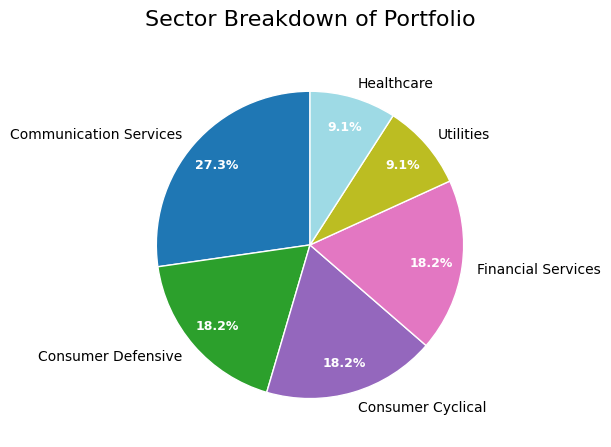

In [95]:
top_stocks = df_final.copy()

sectors = []
for t in top_stocks["Ticker"]:
    try:
        info = yf.Ticker(t).info
        sector = info.get('sector', 'Unknown')
        if sector is None or sector == '':
            sector = 'Unknown'
        sectors.append(sector)
    except Exception as e:
        print(f"Error getting sector for {t}: {e}")
        sectors.append('Unknown')

top_stocks["Sector"] = sectors

sector_counts = (
    top_stocks["Sector"]
    .fillna("Unknown")
    .replace("", "Unknown")
    .value_counts()
)

plt.figure(figsize=(6, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(sector_counts)))

wedges, texts, autotexts = plt.pie(
    sector_counts.values,
    labels=sector_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    pctdistance=0.8,
    wedgeprops=dict(edgecolor="w")
)

plt.title("Sector Breakdown of Portfolio", fontsize=16, pad=20)

for text in texts:
    text.set_fontsize(10)
    
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_weight('bold')

plt.tight_layout()
plt.show()


### **Weight and Transaction Logic**


We now have our most stable stocks to build our portfolio. 

**Problem:** With a budget of CAD 1,000,0000, we could build an equally weighted portfolio, but that would most likely not give us a 'risk-free' portfolio. This is because despite all being stable, some stocks are more volatile than others. More volatility means they would mke the portfolio risky.


**Solution:** To solve this problem, we will be applying the minimum-variance strategy from the Modern Portfolio Theory by Harry Markowitz. The core idea of this strategy is that risk and returns must be evaluated together. allocate weights to these stocks such that we get a low risk, therefore low return, portfolio. Before doing this, let us observe the graph below:

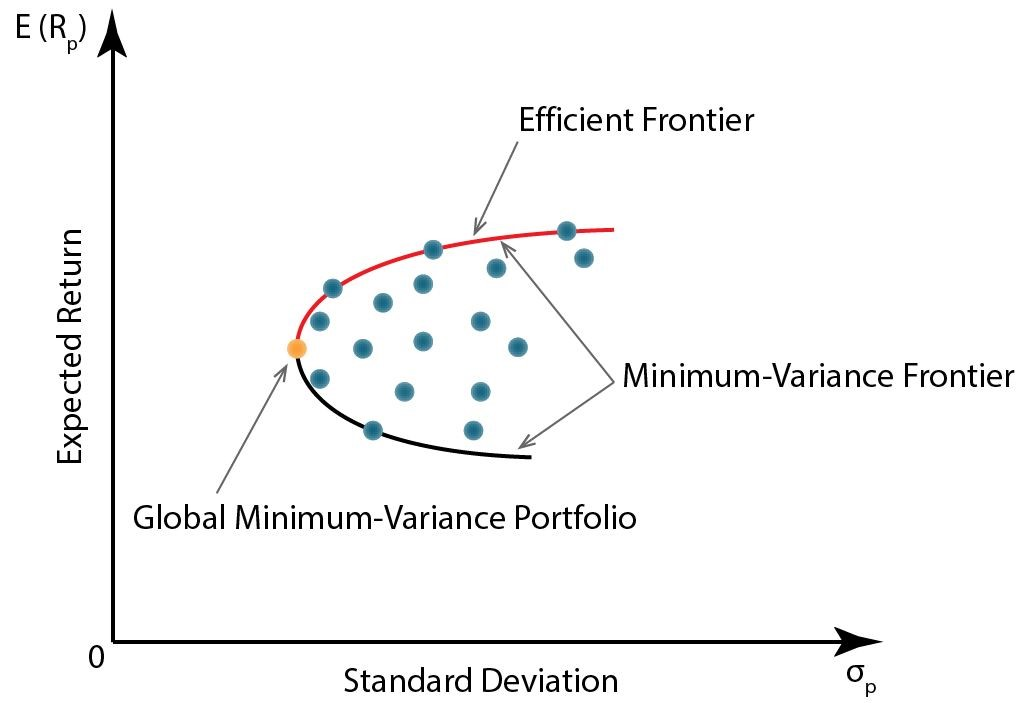

This graph highlights the Minimum-Variance Frontier, which shows the lowest risk portfolio for every expected return. Here, the Global Minimum-Variance Portfolio is the most optimal portfolio is the portfolio with the lowest risk that can be produced. This is what we will aim to find for our 'risk-free' strategy.

**Strategy:**

- Portfolio Risk (Variance):

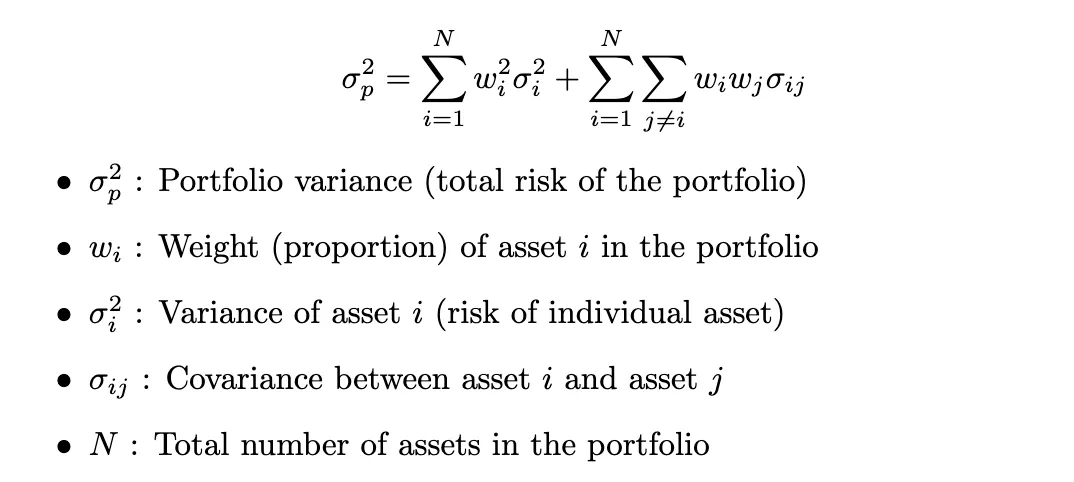

The total risk of a portfolio depends on the individual variance of each asset, the covariance between assets and their weights. With this formula, the optimization strategy will find a combination of weights that will minimize the risk.

We will use Sequential Least Squares Quadratic Programming (SLSQP) to solve this. This optimazation algorithm is used for our nonlinear function, with has equality and inequalty constraints, along with bounds. SLSQP will essentially find the optimal weights for each stock in the portfolio.

We also realise that in order to meet the maximum and minimum weight constraints, we may not end up producing the Global Minimum-Variance portfolio for our selected stocks. Regardless, we will find one with weights distributed such that the portfolio is as 'risk-free' as possible.

*References for the code below:*

- numpy function used: 
https://numpy.org/doc/stable/reference/generated/numpy.dot.html
https://www.geeksforgeeks.org/python/numpy-dot-python/
https://numpy.org/doc/stable/reference/generated/numpy.array.html

- Minimum Variance:
https://medium.com/@BorisGerat/mean-variance-and-minimum-variance-portfolio-models-in-python-64a5c6b57b2d
https://analystprep.com/cfa-level-1-exam/portfolio-management/minimum-variance-portfolios/


### **Transaction Logic:**

For the transaction logic, we first have to consider the transaction fee. According to the assignment's rules, we will be charged $2.15 USD flat or $0.001 USD per share purchased (whichever is smaller), regardless of the currency in which we purchase. Therefore, this will be our strategy:

- Retrieve the USDCAD exchange rate
- Find the minimum transaction fee
- Subtract the transaction fee found from the budget
- Finalise the allocation of the new budget based on the weightage of each stock

In [96]:
top_tickers = df_final['Ticker'].tolist()
daily_returns_pf = pd.DataFrame()

for i in top_tickers:
    ticker = yf.Ticker(i)
    ticker_hist = ticker.history(start = long_term_start_date,end = end_date)
    daily_returns_pf[i] = ticker_hist['Close'].pct_change() 
    
daily_returns_pf = daily_returns_pf.dropna()
cov_matrix = daily_returns_pf.cov()
cov_matrix.head()

,SO,T.TO,PEP,COST,TD,ABBV,RY.TO,LOW,CMCSA,GOOG,AW.TO
SO,0.000125,3.704255e-05,0.000076,0.000028,1.832641e-05,0.000064,0.000022,0.000036,2.600119e-05,-0.000046,0.000008
T.TO,0.000037,1.405237e-04,0.000044,0.000016,-4.718235e-07,0.000018,0.000003,0.000032,-3.324305e-07,-0.000019,0.000013
PEP,0.000076,4.362905e-05,0.000198,0.000043,2.097759e-05,0.000092,0.000036,0.000068,5.447381e-05,-0.000027,0.000025
COST,0.000028,1.605930e-05,0.000043,0.000182,3.370697e-05,0.000046,0.000048,0.000067,4.745987e-05,0.000040,0.000022
TD,0.000018,-4.718235e-07,0.000021,0.000034,1.186401e-04,0.000033,0.000040,0.000050,4.748179e-05,0.000060,0.000014


In [97]:
budget = 1000000
num_tickers = len(df_final)
min_weight = (100 / (2 * num_tickers)) / 100
max_weight = 15 / 100

# The following function calculates the portfolio variance using the dot product of the covariance matrix and weights followed by the dot product
# of that calculation and weights. This is the daily variance so we multiply by 252 (avg number of trading days)
def portfolio_variance(weight): 
    portfolios_variance = np.dot(weight, np.dot(cov_matrix, weight))
    return portfolios_variance * 252

# We set some inital weights according to the number of tickers. These weights will be adjusted later
weight_1 = np.array([1/num_tickers] * num_tickers)

# The following loop bounds the weight to between the minimum and
# maximum weight constraints given
bounds=[]
for i in range(num_tickers): 
    bounds.append((min_weight, max_weight))

# The following function defines some constraints for allocating the weights to the stocks: expected return and total weight (must sum to 1)
def weight_rule(weight):
    total_weight = weight.sum()
    return total_weight-1 # Subtract 1 because we want this to equal 0 when put into our contraints

# Constraints for SLSQP
constraints = [{
    'type': 'eq', 
     'fun': weight_rule
     }]

# This solves the optimization problem using Sequential Least Squares Quadratic Programming (SLSQP)
best_weights = minimize(portfolio_variance,weight_1,method='SLSQP',constraints=constraints,bounds=bounds)
weights = best_weights.x


usdcad = yf.Ticker("USDCAD=X")
usdcad_rate = usdcad.history("1d")['Close'].iloc[-1]

close_price =[]
currencies = []

for t in top_tickers:
    ticker = yf.Ticker(t)
    ticker_hist = ticker.history(start=short_term_start_date,end=end_date)['Close']
    close_price1 =ticker_hist.iloc[-1] # Last day close price
    currency = ticker.info.get('currency', 'USD')

    if currency == 'USD': # Convert USD close prices to CAD
        close_price1 *= usdcad_rate

    close_price.append(close_price1)
    currencies.append(currency)

close_price = np.array(close_price) 
CAD_allocation = weights * budget 
num_shares_inital = CAD_allocation/ close_price 
total_shares = num_shares_inital.sum()

# Transaction fees, flat 2.15 or per share 0.001 both USD
transaction_fee_usd = 2.15
transaction_fee_usd_per_share = 0.001 * total_shares

# We find the lower fee and subtract that frm our budget of $1,000,000 CAD
transaction_fee = min(transaction_fee_usd,transaction_fee_usd_per_share)

transaction_fee *= usdcad_rate # Converts to CAD
total_budget = budget - transaction_fee
# The following is the final allocation of the total budget
CAD_allocation_final = weights *total_budget

# Total amount spent
total_cost = CAD_allocation_final.sum() + transaction_fee

# We make a new df with our weights and CAD allocation
df_complete = df_final.copy() 
df_complete['Weight'] = weights
df_complete['Invested CAD'] = np.round(CAD_allocation_final,2)
df_complete.reset_index(drop=True, inplace=True)
df_complete[['Ticker','Weight','Invested CAD']]
df_complete

,Ticker,STAB,Beta,MarketCap,Average Correlation,Score,Weight,Invested CAD
0,SO,0.008318,0.003130,0.381198,0.068692,0.078306,0.150000,149999.55
1,T.TO,0.011080,0.000000,0.510131,0.026666,0.087618,0.150000,149999.55
2,PEP,0.063244,0.051687,0.307661,0.116038,0.110794,0.045455,45454.41
3,COST,0.059720,0.252956,0.236794,0.183152,0.155786,0.056562,56561.87
4,TD,0.036067,0.187315,0.343130,0.216130,0.157392,0.150000,149999.55
5,ABBV,0.142299,0.160059,0.233457,0.139477,0.158819,0.045455,45454.41
6,RY.TO,0.000000,0.349765,0.264731,0.269312,0.176991,0.150000,149999.55
7,LOW,0.103692,0.287689,0.349495,0.250355,0.214028,0.045455,45454.41
8,CMCSA,0.124425,0.271083,0.380983,0.220271,0.216202,0.045455,45454.41
9,GOOG,0.203511,0.468006,0.000000,0.167994,0.217004,0.057368,57367.58


### *Results:*

Now that we've created our final portfolio, we want to see how successful we were. To do this, we will calculate the following:

- Sharpe Ratio: The Sharpe Ratio of the portfolio will tell us the risk adjusted return.

- Standard Deviation: The Standard Deviation of the portfolio will tell us the risk of the portfolio. We have aimed, through our strategies so far, to have an almost **risk-free** portfolio.

- Portfolio Variation: A low variance is what we aim for, since it would mean that the portfolio is stable.

- Transaction Fee, Invested Budget and Total Budget: Through these, we wish to confirm that the allocation of our budget was correct.

In [98]:
num_trading_days = 252
# CND T-bill 1 year rate (Nov 18) extracted from Bank of Canada divided by 252 approximate trading days in 2025 to extract daily rf
Rf = 2.36/100
portfolio_daily_returns = np.dot(daily_returns_pf,weights)

std = portfolio_daily_returns.std() * np.sqrt(num_trading_days) # sigma p

return_portfolio = portfolio_daily_returns.mean() * num_trading_days # Rp

sharpe_ratio = (return_portfolio - Rf)/std
portfolio_var = portfolio_variance(weights)

print(f"The Portfolio's Sharpe Ratio is {np.round(sharpe_ratio,4)}")
print(f"The Portfolio's Standard Deviation (risk) is {np.round(std,4)}")
print(f"The Portfolio's Variance is {np.round(portfolio_var,4)}")
print(f"The Total Transaction Fee for the Portfolio is {np.round(transaction_fee,2)}")
print(f"The Total Amount Invested in the Portfolio is {np.round(total_budget,2)}")
print(f"The Total Budget of the Portfolio is {np.round(total_cost,4)}")

The Portfolio's Sharpe Ratio is 0.5637
The Portfolio's Standard Deviation (risk) is 0.1031
The Portfolio's Variance is 0.0107
The Total Transaction Fee for the Portfolio is 3.02
The Total Amount Invested in the Portfolio is 999996.98
The Total Budget of the Portfolio is 1000000.0


### *Discussing the results:*

We will first have to note that making a 'risk-free' portfolio is essentially impossible with the stocks we use. In light of that,

- Sharpe Ratio: The sharpe ratio is a little above 1, which indicates that the portfolio has a moderate risk-adjusted performance. Despite this, the returns on our portfolio are low.

- Standard Deviation: The Standard Deviation of the portfolio which is isn't zero, but for an annual analysis, indicates a very low risk portfolio.

- The portfolio's Variance is also very low, indicating a low risk portfolio.

- The Transaction Fee is quite low, therefore we know that $2.15 USD was the minimum.

- The Invested Budget was close to $1,000,000 CAD, which is what we wanted.

- The Total Budget adds back upto $1,000,000 CAD, therefore we know that our transaction fee and allocation was correct.

### **Calculating Beta**

- To calculate Beta, we will first calculate the benchmark average of TSX and S&P100 since our portfolio includes stocks from both.

- We will then calculate Beta using this formula:

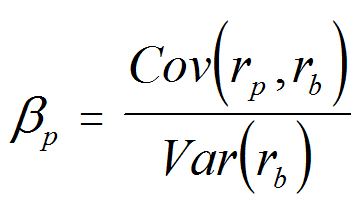

but we will calculate the covariance of our portfolio and the benchmark average, then divide it by the benchmark variance.

In [99]:
#Calculating the Beta

tsx = yf.Ticker('^GSPTSE')
sp100 = yf.Ticker('^GSPC')

tsx_hist = tsx.history(start=long_term_start_date, end=end_date)['Close']
sp100_hist = sp100.history(start=long_term_start_date, end=end_date)['Close']

tsx_returns = tsx_hist.pct_change().dropna()
sp100_returns = sp100_hist.pct_change().dropna()

market_df ={
    'TSX':tsx_returns,
    'SP100': sp100_returns
    }

market_df = pd.DataFrame(market_df)
market_df = market_df.dropna()

# We want to take the benchmark average of the two markets to calculate Beta
market_df['Benchmark_avg'] = market_df.mean(axis=1)

portfolio_returns = pd.Series(portfolio_daily_returns, index=daily_returns_pf.index)

final_df = {
    'Portfolio_return': portfolio_returns,
    'Benchmark_avg': market_df['Benchmark_avg']
}

final_df = pd.DataFrame(final_df)

# We make a combined data frame so that we can drop dates that are not common, as follows:
final_df = final_df.dropna()

# Now applying the Beta formula:

cov_matrix_portoflio = final_df['Portfolio_return'].cov(final_df['Benchmark_avg'])
benchmark_var = final_df['Benchmark_avg'].var()

beta_portfolio = cov_matrix_portoflio/benchmark_var

print(f"The Portfolio's Beta is {np.round(beta_portfolio,4)}")

The Portfolio's Beta is 0.429


### *Result:*

We get a low Beta value, which tells us that the portfolio is low volatility and has relatively low sensitivity to the market.

### **Backtesting**

Below is a back test of our code, which will let us get a general idea of our portfolios performance using past data. We will look at both short and long term data to see how our portfolio value varies over time. Some considerations to keep in mind prior to looking to our back testing results include:
- The last year has been relatively postive for the stock market, with teh SNP500 up 11.00% this year. 
- Exchange rates can impact the calculated portfolio value: the given exchange rate on the date of purchase and sale of our assets have an impact on our calculated values. 
- The return itself is not important, the key detail is that the risk on the portfolio be as low as possible. For this reason, the annual risk is important to consider. For this application we are looking at annualized risk by multiplying the daily standard deviation in our portfolio value with the square root of 252 (number of trading days in a year).


In [100]:
# Creating a portfolio backtest 
budget = 1000000
df_complete1 = df_complete.copy()

# Tickers and weights from our optimized portfolio
tickers = df_complete1['Ticker'].tolist()
weights = df_complete1['Weight'].tolist()

# Creating backtest periods consisting of the last 4 full weeks, roughly a full month, and a year. 
test_periods = [
    ['2025-11-10', '2025-11-15'],  # Nov 10–14
    ['2025-11-03', '2025-11-08'],  # Nov 3–7
    ['2025-10-27', '2025-11-01'],  # Oct 27–31
    ['2025-10-20', '2025-10-25'],  # Oct 20–24
    ['2025-10-20', '2025-11-15'],  # Oct 20–Nov 14 
    ['2024-11-15', '2025-11-15']   # Full year period
]

# Getting the exchange rate so that we can convert stocks with prices in USD to CAD
fx = yf.Ticker("USDCAD=X").history(start='2024-11-01', end='2025-11-20')
fx = fx['Close']
fx.index = fx.index.tz_localize(None)

portfolio_values_list = []

# Looping through each backtest period
for start_date, end_date in test_periods:

    print(f"\nBacktest period: {start_date} to {end_date}")

    date_index = pd.date_range(start=start_date, end=end_date, freq='B')
    portfolio_values = pd.Series(0.0, index=date_index)

    #Looping through each stock
    for t, w in zip(tickers, weights):

        ticker = yf.Ticker(t)

        # Getting the prices
        hist = ticker.history(start=start_date, end=end_date)['Close']
        hist.index = hist.index.tz_localize(None)
        hist = hist.reindex(date_index, method='ffill')

        # Check if currency is USD and convert to CAD if so
        currency = ticker.info.get("currency")
        if currency == "USD":
            fx_align = fx.reindex(date_index, method='ffill')
            hist = hist * fx_align

        # Buy shares at the start of the period
        first_price = hist.iloc[0]
        shares = (budget * w) / first_price

        # Getting values
        position_value = hist * shares
        portfolio_values += position_value


    start_val = portfolio_values.iloc[0]
    end_val = portfolio_values.iloc[-1]
    pct_ret = (end_val - start_val) / start_val

    print(f"  Start Value (CAD): {start_val:,.2f}")
    print(f"  End Value (CAD):   {end_val:,.2f}")
    print(f"  Return (%):        {pct_ret*100:.3f}%")

    # Save values to plot later
    portfolio_values_list.append((start_date, end_date, portfolio_values))



last_period_values = portfolio_values_list[-1][2]

# Daily percentage returns
daily_returns = last_period_values.pct_change().dropna()

# Daily STD
std_daily = daily_returns.std()

# Annualized STD
std_annual = std_daily * np.sqrt(252)

print("\n1-Year Backtest Risk Calculations")
print(f"  Daily Std Dev:   {std_daily:.5f}")
print(f"  Annualized Risk: {std_annual:.5f}")



Backtest period: 2025-11-10 to 2025-11-15
  Start Value (CAD): 1,000,000.00
  End Value (CAD):   995,979.97
  Return (%):        -0.402%

Backtest period: 2025-11-03 to 2025-11-08
  Start Value (CAD): 1,000,000.00
  End Value (CAD):   1,000,894.54
  Return (%):        0.089%

Backtest period: 2025-10-27 to 2025-11-01
  Start Value (CAD): 1,000,000.00
  End Value (CAD):   983,796.89
  Return (%):        -1.620%

Backtest period: 2025-10-20 to 2025-10-25
  Start Value (CAD): 1,000,000.00
  End Value (CAD):   995,725.72
  Return (%):        -0.427%

Backtest period: 2025-10-20 to 2025-11-15
  Start Value (CAD): 1,000,000.00
  End Value (CAD):   977,448.21
  Return (%):        -2.255%

Backtest period: 2024-11-15 to 2025-11-15
  Start Value (CAD): 1,000,000.00
  End Value (CAD):   1,160,628.77
  Return (%):        16.063%

1-Year Backtest Risk Calculations
  Daily Std Dev:   0.00671
  Annualized Risk: 0.10654


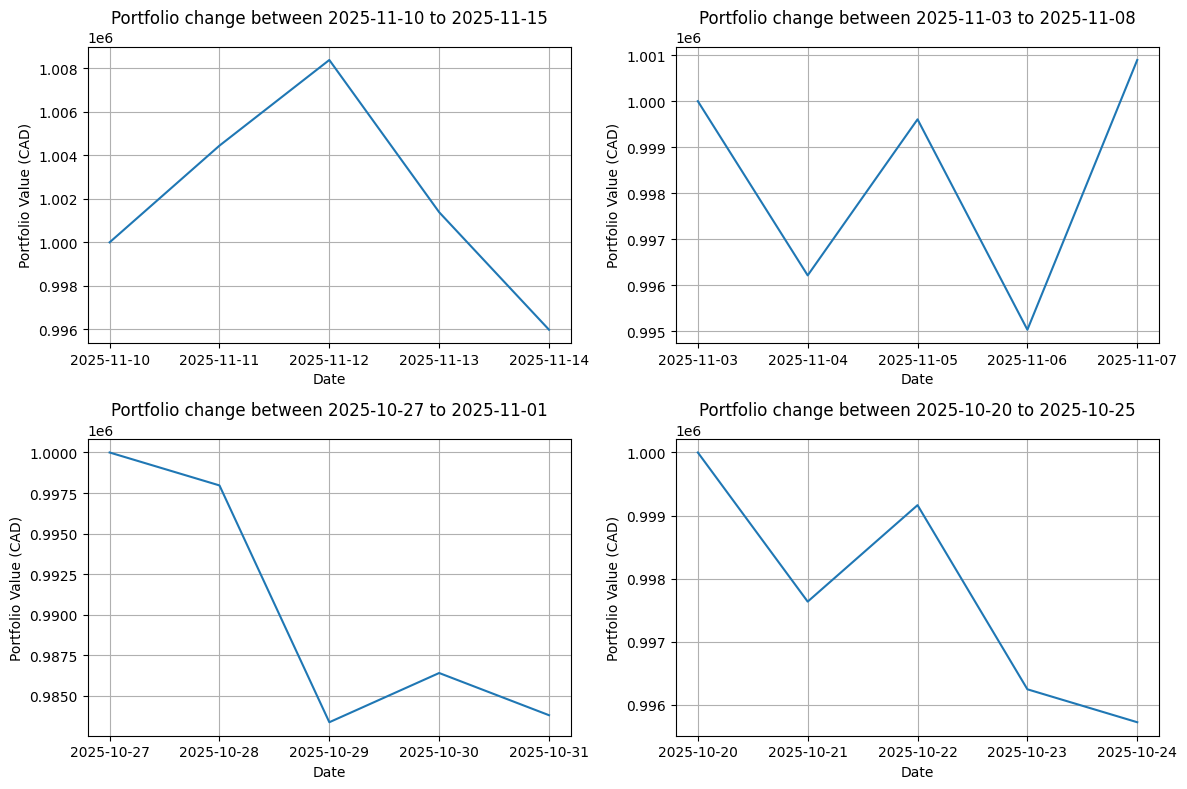

In [101]:
# Make a 2x2 subplot grid to hold the 4 weekly backtest data graphs 
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten() 

plot_index = 0

# Loop over the first 4 weekly test periods 
for start_date, end_date, portfolio_values in portfolio_values_list[:4]:
    ax = axs[plot_index]

    ax.plot(portfolio_values.index, portfolio_values.values)
    ax.set_title(f"Portfolio change between {start_date} to {end_date}")
    ax.set_xlabel("Date")
    ax.set_xticks(ax.get_xticks()[::2])  # show every other tick to prevent overlap on dates on x axis
    ax.set_ylabel("Portfolio Value (CAD)")
    ax.grid(True)

    plot_index += 1

plt.tight_layout()
plt.show()


In [102]:
today_end_date = "2025-11-21" 
closing_price = [] 

for i in top_tickers: 
    ticker = yf.Ticker(i) 
    ticker_hist = ticker.history(start=start_date,end=today_end_date)['Close'] 
    price =ticker_hist.iloc[-1] 
    # last day close price
    currency = ticker.info.get('currency', 'USD') 
    if currency == 'USD':
        price *= usdcad_rate 
    closing_price.append(price) 

Portfolio_Final = pd.DataFrame() 
Portfolio_Final['Ticker'] = top_tickers 
Portfolio_Final['Price (in CAD)'] = closing_price 
Portfolio_Final = Portfolio_Final.dropna() 
Portfolio_Final
num_shares_final = CAD_allocation_final/closing_price

# No currency column since all prices are in CAD
Portfolio_Final['Shares']=num_shares_final
Portfolio_Final['Value'] = num_shares_final * closing_price
Portfolio_Final['Weight']= df_complete['Weight']*100
Portfolio_Final

,Ticker,Price (in CAD),Shares,Value,Weight
0,SO,124.609137,1203.760415,149999.546275,15.000000
1,T.TO,18.840000,7961.759292,149999.546275,15.000000
2,PEP,205.548106,221.137567,45454.407962,4.545455
3,COST,1256.769713,45.005756,56561.871535,5.656204
4,TD,114.409111,1311.080423,149999.546275,15.000000
5,ABBV,322.813212,140.807149,45454.407962,4.545455
6,RY.TO,207.979996,721.221028,149999.546275,15.000000
7,LOW,321.378168,141.435892,45454.407962,4.545455
8,CMCSA,37.465747,1213.225719,45454.407962,4.545455
9,GOOG,407.972891,140.616162,57367.582214,5.736776


In [107]:
weighted_sum = round(Portfolio_Final['Weight'].sum(),2)
total_CAD_invested = Portfolio_Final['Value'].sum()
total_CAD_budget = total_CAD_invested + transaction_fee
print(f" The sum of all the Weights =  {weighted_sum}")
print(f" The sum of all the Portfolio Values (Total CAD Invested) = {np.round(total_CAD_invested,2)}")
print(f" The Total CAD Budget = {np.round(total_CAD_budget,2)}")

 The sum of all the Weights =  100.0
 The sum of all the Portfolio Values (Total CAD Invested) = 999996.98
 The Total CAD Budget = 1000000.0


In [108]:
Portfolio_Final[['Ticker','Shares']].to_csv("output.csv", index=False)

The following team members made a meaningful contribution to this assignment:
Jay, Manal, Sardul